In [1]:
# Setting the PythonPath
import os
import sys

# # Get the parent directory of the current working directory
parent_dir = os.path.dirname(os.getcwd())

# Add the current directory to PYTHONPATH
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

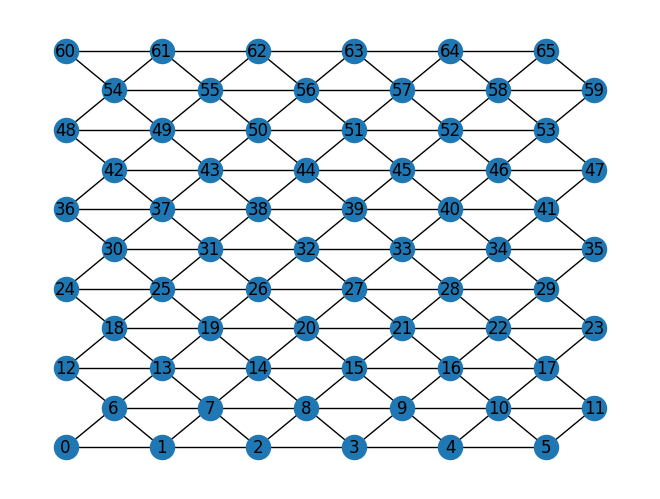

In [8]:
from qadence import Register
n = 10

reg_triang = Register.triangular_lattice(n_cells_row = 10, n_cells_col = 10)
reg_triang.draw()

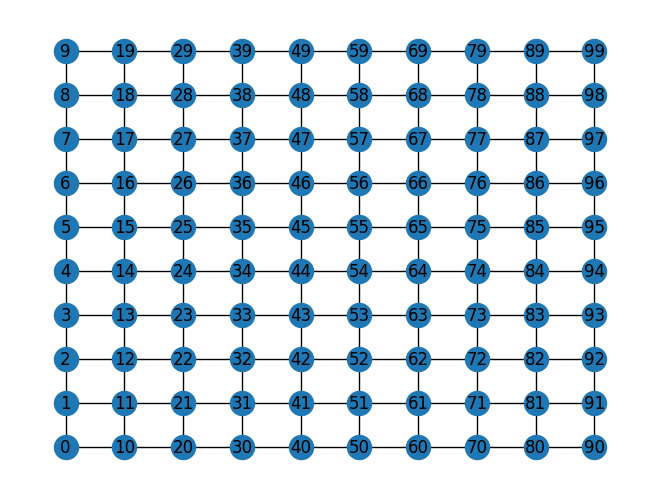

In [12]:
n = 10
reg_rect = Register.rectangular_lattice(qubits_row = n, qubits_col = n)
reg_rect.draw()